In [126]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size': 16}) 

import numpy as np
from scipy.interpolate import InterpolatedUnivariateSpline as IUS
import phenom

import lal
import lalsimulation as lalsim



In [127]:
import sys
sys.path.append("..")

In [128]:
import lalutils

In [129]:
import greedyrb
# import gprfit
import fitslr

In [130]:
import surrogate

In [131]:
import george

# data acquisition

We need a function that we can call to
generate data in a uniform way.

We will use this to generate the data for:
 - the seed basis
 - additional training sets and
 - validation sets

In [132]:
def gen_2d_massratio_data(q_array, chi_array, M, deltaT=1/1024., f_min=10,
                         approximant=lalsim.SEOBNRv4P, inclination=0,
                          t_min=-4000, t_max=100, npts=5000
                         ):


    new_times = np.linspace(t_min, t_max, npts)
    
    data = []
    coords = []
    
    for q, chi in zip(q_array, chi_array):
#         print(q,chi)
        m1, m2 = phenom.m1_m2_M_q(M, q)
        pp = dict(m1=m1, m2=m2, deltaT=deltaT,
                  f_min=f_min,
                  inclination=inclination,
                  S1z=chi, S2z=chi,
                  approximant=approximant
                 )
        p = lalutils.gen_td_wf_params(**pp)
        t, amp, phase = lalutils.gen_td_wf(p, t_min=t_min, t_max=t_max)
              
        iamp = IUS(t, amp)
        iphase = IUS(t, phase)
        
        # interpolate around peak
#         max_amp_idx = amp.argmax()
#         tpeak = t[max_amp_idx]
#         t_fine = np.linspace(tpeak-10, tpeak+10,1000)
#         amp_fine = iamp(t_fine)
#         tpeak = t_fine[amp_fine.argmax()]
        
        
#         iamp = IUS(t-tpeak, amp)
#         iphase = IUS(t-tpeak, phase)
        amp = iamp(new_times)
        phase = iphase(new_times)
        

        
        d = {"t":new_times, "amp":amp, "phase":phase}
        
        data.append(d)
        coords.append([q, chi])
    
    n_t_points = len(new_times)
    n_waveforms = len(data)
    ts_amp = np.zeros(shape=(n_waveforms, n_t_points))
    ts_phase = np.zeros(shape=(n_waveforms, n_t_points))
    
    
    
    for i in range(n_waveforms):
        ts_amp[i] = data[i]['amp'] / phenom.eta_from_q(coords[i][0]) / 1e5
        ts_phase[i] = data[i]['phase'] - data[i]['phase'][0]
        
    return new_times, ts_amp, ts_phase, np.array(coords)

In [133]:
qq, cc = np.meshgrid(np.linspace(1,10,3), np.linspace(-0.99,0.99,3))
qq = qq.ravel()
cc = cc.ravel()

In [134]:
seed_x, seed_ts_amp, seed_ts_phase, seed_ts_coords = gen_2d_massratio_data(qq, cc, 100)

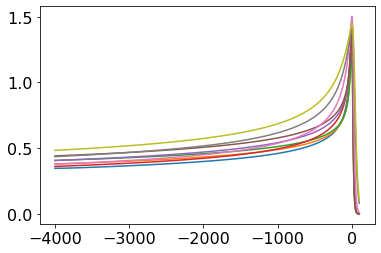

In [135]:
plt.figure()
for s in seed_ts_amp:
    plt.plot(seed_x, s)
# plt.yscale('log')
# plt.xlim(-200, 100)

In [136]:
plt.figure()
for s in seed_ts_phase:
    plt.plot(seed_x, s)
# plt.xscale('log')

# run

In [137]:
# Make integration rule

int_range = [seed_x[0], seed_x[-1]]
int_num = len(seed_x)

integration = greedyrb.Riemann(int_range, num=int_num)
x = integration.nodes  # Define x for convenience

In [138]:
sur = surrogate.Surrogate1D(integration)

In [139]:
sur.build_seed_basis(ts=seed_ts_amp, ts_coords=seed_ts_coords)

building seed basis


In [140]:
sur.grb.greedy_points

array([[ 1.  , -0.99],
       [ 5.5 , -0.99],
       [10.  , -0.99],
       [ 1.  ,  0.  ],
       [ 5.5 ,  0.  ],
       [10.  ,  0.  ],
       [ 1.  ,  0.99],
       [ 5.5 ,  0.99],
       [10.  ,  0.99]])

In [141]:
# check seed basis and add points
_, ts_amp, _, ts_coords = gen_2d_massratio_data(
    np.random.uniform(1,10,100),
    np.random.uniform(-0.99,0.99,100),
    100)

In [249]:
sur.run_greedy_sweep(ts_amp, ts_coords, verbose=True, greedy_tol=1e-6)

tolerance reached. exiting


In [250]:
sur.grb.greedy_points

array([[ 1.00000000e+00, -9.90000000e-01],
       [ 5.50000000e+00, -9.90000000e-01],
       [ 1.00000000e+01, -9.90000000e-01],
       [ 1.00000000e+00,  0.00000000e+00],
       [ 5.50000000e+00,  0.00000000e+00],
       [ 1.00000000e+01,  0.00000000e+00],
       [ 1.00000000e+00,  9.90000000e-01],
       [ 5.50000000e+00,  9.90000000e-01],
       [ 1.00000000e+01,  9.90000000e-01],
       [ 9.65911881e+00,  9.08089940e-01],
       [ 9.28203307e+00,  9.78124681e-01],
       [ 9.89439444e+00,  7.40957106e-01],
       [ 1.25158974e+00, -8.88301224e-01],
       [ 2.67309846e+00,  5.31626774e-01],
       [ 1.02207745e+00, -2.65320522e-01],
       [ 2.03025304e+00, -9.09668606e-01],
       [ 3.37938783e+00, -2.10870550e-01],
       [ 8.64343262e+00,  8.56750520e-01],
       [ 3.66761821e+00, -5.98160046e-01],
       [ 1.51101571e+00,  9.75322413e-01],
       [ 1.39056577e+00, -9.68014321e-01],
       [ 1.08054966e+00,  8.30048243e-01],
       [ 8.47092518e+00,  4.34452093e-01],
       [ 5.

In [144]:
# build eim
# eim needs to be built from training_set at the greedy points
_, ts, _, ts_coords = gen_2d_massratio_data(sur.grb.greedy_points[:,0], sur.grb.greedy_points[:,1], 100)

In [145]:
sur.build_eim(ts)

In [146]:
np.log(sur.grb.greedy_points[:,0])

array([0.        , 1.70474809, 2.30258509, 0.        , 1.70474809,
       2.30258509, 0.        , 1.70474809, 2.30258509, 2.26790242,
       2.2280806 , 2.29196838, 0.22441453, 0.98323827, 0.02183727,
       0.70816044, 1.21769458, 2.1567998 , 1.29954246, 0.41278208,
       0.32971069, 0.07746985])

In [147]:
sur.grb.nbasis

22

In [251]:

# fit_eim
solver=george.HODLRSolver
# solver=george.BasicSolver
# sur.fit_eim_2d(solver=solver, verbose=False)
sur.fit_eim_2d(method='lr', maxdegs=[4,4], solver=george.HODLRSolver, verbose=False, jitter=1e-4)
# sur.fit_eim_2d(method='gpr', maxdegs=[4], solver=george.HODLRSolver, verbose=False, jitter=1e-4)

ValueError: shapes (15,35) and (34,) not aligned: 35 (dim 1) != 34 (dim 0)

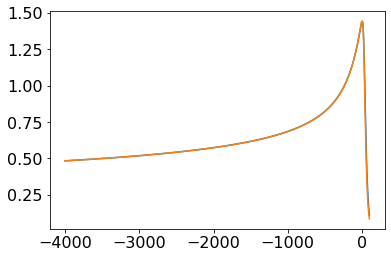

In [171]:
plt.figure()
plt.plot(x, ts[8])
plt.plot(x, sur.predict_2d(*ts_coords[8]))

In [164]:
_, vts, _, vts_coords = gen_2d_massratio_data(
    np.random.uniform(1,10,100),
    np.random.uniform(-0.99,0.99,100),
    100)

In [151]:
np.array([[1,1]]).shape

(1, 2)

In [152]:
len(vts_coords)

100

In [172]:
model_errors, worst_case, worst_error_index = sur.validate_surrogate_2d(vts, vts_coords)
print(f"worst error = {model_errors[worst_error_index]}")
print(f"worst case = {worst_case}")

worst error = 1.3673972924996338
worst case = [8.54025433 0.45089975]


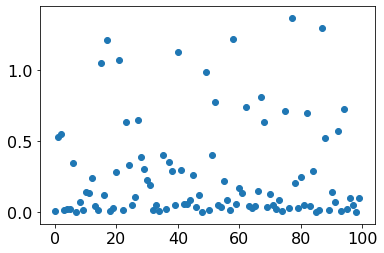

In [173]:
plt.figure()
plt.scatter(range(len(vts_coords)), model_errors)

(-100, 100)

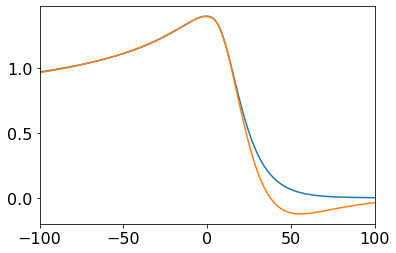

In [176]:
plt.figure()
plt.plot(x, vts[worst_error_index])
plt.plot(x, sur.predict_2d(*vts_coords[worst_error_index]))
plt.xlim(-100,100)

In [175]:
%%timeit
sur.predict_2d(*vts_coords[worst_error_index])

2.99 ms ± 21.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


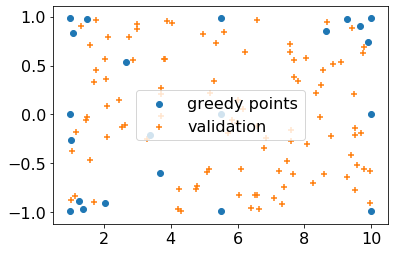

In [177]:
plt.figure()
plt.scatter(sur.grb.greedy_points[:,0], sur.grb.greedy_points[:,1], label='greedy points')
plt.scatter(vts_coords[:,0], vts_coords[:,1], marker='+', label='validation', zorder=-1)
plt.legend()

In [253]:
# iteratively add points by testing the model

err_tol = 0.02
max_iter = 20

for i in range(max_iter):
    print(i)

    _, vts, _, vts_coords = gen_2d_massratio_data(
        np.random.uniform(1,10,100),
        np.random.uniform(-1,1,100),
        100)
    
    model_errors, worst_case, worst_error_index = sur.validate_surrogate_2d(vts, vts_coords)
    err = model_errors[worst_error_index]
    print(f"worst error = {err}")
    print(f"worst case = {worst_case}")
    
    
    if err <= err_tol:
        print("stopping")
        break
    else:
        # add the worst case to the basis and re-fit
        vts_worst = vts[worst_error_index]
        vts_coords_worst = vts_coords[worst_error_index]
        sur.run_greedy_sweep(vts_worst.reshape(1,-1), vts_coords_worst.reshape(1, -1), greedy_tol=1e-15)
        # build eim
        # eim needs to be built from training_set at the greedy points
        _, ts, _ ,_ = gen_2d_massratio_data(
            sur.grb.greedy_points[:,0],
            sur.grb.greedy_points[:,1],
            100)
        sur.build_eim(ts)

        # fit_eim
        solver=george.HODLRSolver
        # solver=george.BasicSolver
        sur.fit_eim_2d(method='lr', maxdegs=[3,3], solver=george.HODLRSolver, verbose=False, jitter=1e-4)
        # sur.fit_eim_2d(method='gpr', maxdegs=[4], solver=george.HODLRSolver, verbose=False, jitter=1e-4)


0
worst error = 0.940825144541966
worst case = [7.32781534 0.99115652]
step = 0, error = 2.9460708312905384e-08


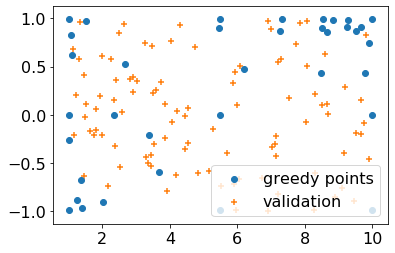

In [254]:
plt.figure()
plt.scatter(sur.grb.greedy_points[:,0], sur.grb.greedy_points[:,1], label='greedy points')
plt.scatter(vts_coords[:,0], vts_coords[:,1], marker='+', label='validation', zorder=-1)
plt.legend()

In [255]:
sur.grb.greedy_points[-1]

array([7.32781534, 0.99115652])

In [256]:
sur.grb.greedy_points.shape

(36, 2)

In [257]:
sur.fit_eim_2d(method='lr', maxdegs=[3,3], solver=george.HODLRSolver, verbose=False, jitter=1e-4)

(-100, 100)

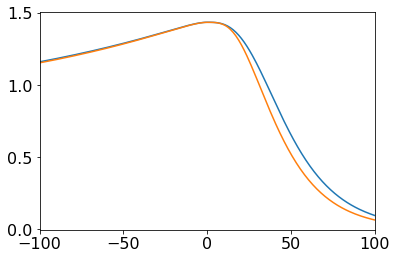

In [258]:
plt.figure()
plt.plot(x, vts[worst_error_index])
plt.plot(x, sur.predict_2d(*vts_coords[worst_error_index]))
plt.xlim(-100,100)

In [259]:
_, vts, _, vts_coords = gen_2d_massratio_data(
    np.random.uniform(1,10,100),
    np.random.uniform(-0.99,0.99,100),
    100)

In [261]:
model_errors, worst_case, worst_error_index = sur.validate_surrogate_2d(vts, vts_coords)
print(f"worst error = {model_errors[worst_error_index]}")
print(f"worst case = {worst_case}")

worst error = 0.9064890207960865
worst case = [5.6928832  0.88748325]


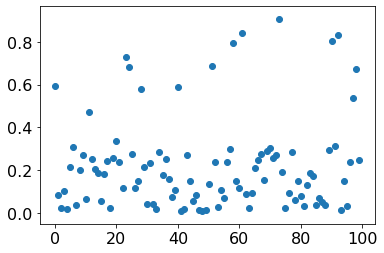

In [262]:
plt.figure()
plt.scatter(range(len(vts_coords)), model_errors)

(-100, 100)

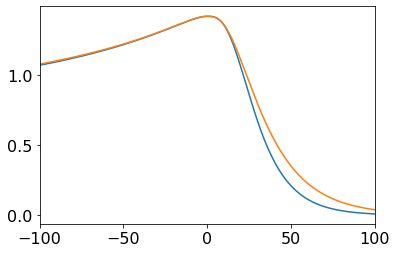

In [267]:
plt.figure()
plt.plot(x, vts[worst_error_index])
plt.plot(x, sur.predict_2d(*vts_coords[worst_error_index]))
plt.xlim(-100,100)